In [126]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
import geopandas as gpd

import osmnx as ox

In [2]:
# %%time
# df_stops = pd.read_pickle("./data/cuebiq/texas_stops_20221021_20221023.pkl")  
# df_stops['Time'] = df_stops['stop_zoned_datetime'].astype(str).str[0:-6]
# df_stops.drop(['stop_zoned_datetime'], axis=1, inplace=True)
# df_stops['Time'] = pd.to_datetime(df_stops['Time'], errors='coerce')
# print(df_stops.shape[0])
# print(df_stops.cuebiq_id.unique().shape[0])

864615
110446
CPU times: user 13.3 s, sys: 715 ms, total: 14 s
Wall time: 14.7 s


In [124]:
df_stops.head(2)

,cuebiq_id,device_type_code,os_name,lat,lng,geohash_id,cluster_size,avg_distance_meters,avg_accuracy_meters,std_accuracy_meters,dwell_time_minutes,timezone_offset_seconds,admin1_id,admin2_id,classification_type,transformation_type,block_group_id,processing_date,country_code,provider_id,event_date,Time
1,6109947610,IDFA,IOS,30.44453,-97.63212,9v6t4q62n,3,4.95331,27.66667,6.35085,60.41667,-18000,US.TX,US.TX.453,WHITELISTED,KEEP,US.TX.453.001841.3,20221021,US,190199,2022-10-21,2022-10-21 09:16:49
6,6109944775,IDFA,IOS,30.41425,-97.67201,9v6t12trv,5,6.44381,26.64200,12.18014,150.75000,-18000,US.TX,US.TX.453,WHITELISTED,KEEP,US.TX.453.001839.1,20221021,US,190199,2022-10-21,2022-10-21 07:03:39


In [6]:
# df_stops_need = df_stops[['cuebiq_id','lat','lng','event_date','Time','dwell_time_minutes']]
# df_stops_need['departure_time'] = df_stops_need['Time'] + pd.to_timedelta(df_stops_need['dwell_time_minutes'], unit='m')
# df_stops_need = df_stops_need[['cuebiq_id','lat','lng','departure_time']]

# import geopandas as gpd

# gdf_stops = gpd.GeoDataFrame(
#     df_stops_need,
#     geometry=gpd.points_from_xy(df_stops_need.lng, df_stops_need.lat),
#     crs="EPSG:4326"
# )
# df_stops_need.head()

# Load traj data

In [12]:
df_traj = pd.read_pickle("./data/cuebiq/texas_traj_20221021_20221023.pkl")  
print(df_traj.shape[0])
print(df_traj.cuebiq_id.unique().shape[0])

100424
7512


In [125]:
df_traj_need = df_traj[(df_traj['start_admin1']=='US.TX')&(df_traj['end_admin1']=='US.TX')]
print(df_traj_need.shape[0])

df_traj_need['cuebiq_trip_km'] = df_traj_need.length_meters/1000
df_traj_need['cuebiq_trip_km'].describe()

97667


count   97667.00000
mean    21.85148   
std     78.55275   
min     0.04014    
25%     0.93240    
50%     4.27115    
75%     22.74442   
max     7373.06359 
Name: cuebiq_trip_km, dtype: float64

In [ ]:
# %%time
# import pandana
# !pandana network does not support weighting network by travel time and speed
# # load existing network data
# nodes = pd.read_csv('./output/nodes.csv', index_col=0)
# print(nodes.shape[0])
# edges = pd.read_csv('./output/edges.csv', index_col=[0,1])
# network = pandana.Network(nodes['x'], nodes['y'], 
#                           edges['from'], edges['to'], edges[['distance']])

In [ ]:
# %%time

# G = ox.graph_from_bbox(bbox=(30.584984, 30.039047, -97.389445, -97.996048), network_type='drive') 

# # Add edge travel time (assumes speed limit if not available)
# G = ox.speed.add_edge_speeds(G)  # Adds estimated speeds (km/h)
# G = ox.speed.add_edge_travel_times(G)  # Adds travel time (seconds)

In [ ]:
# graphml_path = "./output/road_network.graphml"  # GraphML format
# gpkg_path = "./output/road_network.gpkg"  # GeoPackage format

# # Save the graph in GraphML format (recommended for reloading in OSMnx)
# ox.save_graphml(G, filepath=graphml_path)

# # Save as GeoPackage (useful for GIS applications)
# ox.save_graph_geopackage(G, filepath=gpkg_path)

# print("Graph saved successfully!")

# Load Austin OSM network 

In [133]:
# Convert to GeoDataFrames (assuming you have 'x' and 'y' columns for coordinates)
nodes_df = pd.read_csv('./output/osm_nodes.csv')
edges_df = pd.read_csv('./output/osm_edges.csv')

nodes_df['geometry'] = gpd.GeoSeries.from_wkt(nodes_df['geometry'])
edges_df['geometry'] = gpd.GeoSeries.from_wkt(edges_df['geometry'])

nodes_gdf = gpd.GeoDataFrame(nodes_df, crs="EPSG:3857", geometry='geometry')
edges_gdf = gpd.GeoDataFrame(edges_df, crs="EPSG:3857", geometry='geometry')

nodes_gdf = nodes_gdf.set_index('osmid')
edges_gdf.set_index(['u', 'v','key'], inplace=True)

G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)

In [128]:
# %%time
# # impute speed on all edges missing data
# G = ox.routing.add_edge_speeds(G)
# # calculate travel time (seconds) for all edges
# G = ox.routing.add_edge_travel_times(G)

CPU times: user 3.53 s, sys: 51 ms, total: 3.58 s
Wall time: 3.6 s


In [131]:
# # see mean speed/time values by road type
# edges = ox.convert.graph_to_gdfs(G, nodes=False)
# edges["highway"] = edges["highway"].astype(str)
# edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

In [134]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.routing.add_edge_speeds(G, hwy_speeds=hwy_speeds)
G = ox.routing.add_edge_travel_times(G)

In [135]:
%%time
# Get nearest nodes in the road network
orig_node = ox.distance.nearest_nodes(G, df_traj_need.start_lng, df_traj_need.start_lat)
dest_node = ox.distance.nearest_nodes(G, df_traj_need.end_lng, df_traj_need.end_lat)

CPU times: user 423 ms, sys: 0 ns, total: 423 ms
Wall time: 420 ms


In [ ]:
%%time
# Compute shortest travel time (in seconds)
travel_time_sec = ox.routing.shortest_path(G, orig_node, dest_node, weight="travel_time")
travel_time_min = travel_time_sec / 60  # Convert to minutes

In [29]:
# df_test = df_traj_need[df_traj_need['length_km']>1000]
# 'start_lat','start_lng'
# 'end_lat','end_lng'

In [59]:
# first, identify the nearest node (of pandana network) to each lon lat coordinate of road segments
road_start_nodes = network.get_node_ids(df_traj_need.start_lng, df_traj_need.start_lat).values
road_end_nodes = network.get_node_ids(df_traj_need.end_lng, df_traj_need.end_lat).values

In [62]:
len(road_end_nodes)

97667

In [60]:
%%time
distances_list = network.shortest_path_lengths(road_start_nodes, road_end_nodes)
df_traj_need['trip_distance_km'] = distances_list
df_traj_need['trip_distance_km'] = df_traj_need['trip_distance_km']/1000
# pd.Series(distances_list) / 1000 # covert to km

CPU times: user 2.22 s, sys: 0 ns, total: 2.22 s
Wall time: 123 ms


In [73]:
df_traj_needcol = df_traj_need[['cuebiq_id', 'length_km', 'duration_minutes' ,'trip_distance_km']]
df_traj_needcol['diff'] = df_traj_needcol['length_km'] - df_traj_needcol['trip_distance_km']
df_traj_needcol = df_traj_needcol[(df_traj_needcol['diff']<100)&(df_traj_needcol['diff']>-100)]

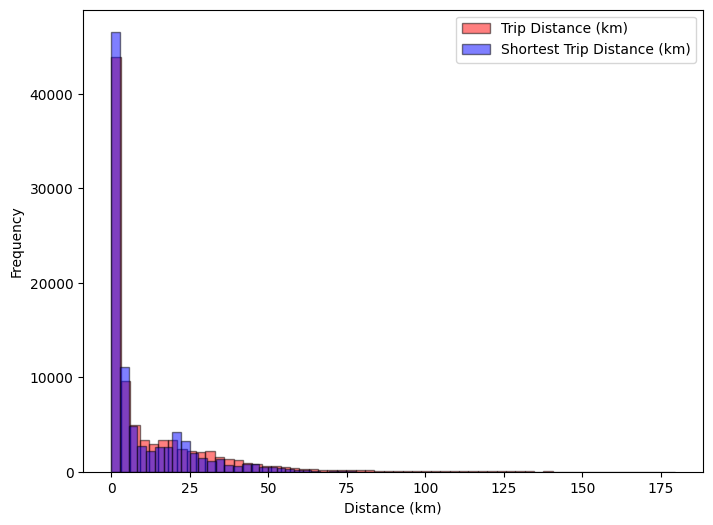

In [83]:
import matplotlib.pyplot as plt

# Plot histograms on the same axis
plt.figure(figsize=(8, 6))
plt.hist(df_traj_needcol['length_km'], bins=60, alpha=0.5, label='Trip Distance (km)', color='red', edgecolor='black')
plt.hist(df_traj_needcol['trip_distance_km'], bins=30, alpha=0.5, label='Shortest Trip Distance (km)', color='blue', edgecolor='black')
# Labels and title
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
# plt.title('Overlayed Histograms of Trip Distance and Length')
plt.legend()

# Show plot
plt.show()

In [75]:
df_traj_needcol['diff'].describe()

count   91196.00000
mean    3.45776    
std     11.87264   
min     -47.53605  
25%     -0.58766   
50%     0.22711    
75%     2.42737    
max     99.92079   
Name: diff, dtype: float64